In [11]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import scipy
import skimage.io as skimage

from glob import glob
from scipy import signal

In [2]:
files = sorted(glob('/Users/sabera.talukder/Desktop/anithaTestData/*.tiff'))
files200 = []
files300 = []
for f in files:
    if re.search('_p200',f):
        files200.append(f)
    
    elif re.search('_p300',f):
        files300.append(f)
        
    else:
        print('error')
        print(f)
        
files200 = np.array(files200)
files300 = np.array(files300)

In [3]:
imgs2 = np.array([skimage.imread(f) for f in files200])

In [4]:
imgs3 = np.array([skimage.imread(f) for f in files300])

In [5]:
dims2 = imgs2.shape[1:]
dims3 = imgs3.shape[1:]

In [6]:
def to_mask(coords, dims):
    mask = np.zeros(dims)
    tst = zip(*coords)
    for idx, item in enumerate(tst):
        if idx == 0:
            row = item
        else:
            col = item
    mask[row, col] = 1
    return mask

In [8]:
# # TODO fix this function
# def adjust_img_vals(imgs, dims):
#     totImg = np.zeros(dims)
#     print(len(imgs))
#     for img in imgs:
#         totImg = totImg + img

#     adjustedTotImg = (totImg / totImg.max() * 255)
#     return adjustedTotImg

In [8]:
with open('neurofinder.02.00/regions/regions.json') as f:
    regions2 = json.load(f)
    
with open('neurofinder.03.00/regions/regions.json') as f:
    regions3 = json.load(f)

mask2 = np.array([(print, to_mask(s['coordinates'], dims2)) for idx, s in enumerate(regions2)])
# concatenating the mask just removes a str from the end of the line
shortMask2 = mask2[:, 1]
# shortMask 2 has 197 individual neurons
# adjustedTot2 = adjust_img_vals(imgs2, dims2)

mask3 = np.array([(print, to_mask(s['coordinates'], dims3)) for idx, s in enumerate(regions3)])
shortMask3 = mask3[:, 1]
# shortMask 3 has 621 individual neurons
# adjustedTot3 = adjust_img_vals(imgs3, dims3)





<font size = '+2'>
    <p>   </p>
    <p>   </p>
    <p>   </p>
    <p>   </p>
    <p>   </p>
    <p>   </p>
    <p>   </p>
    <p>   </p>
That was loading all of the data that we need and visualizing it. Now we will look at creating the masks for each layer of the original image.
    <p>   </p>
    <p>   </p>
    <p>   </p>
    <p>   </p>
    <p>   </p>
    <p>   </p>
    <p>   </p>
    <p>   </p>
</font>

In [9]:
filter3x3 = np.ones([3,3])

In [12]:
# Alll filters will be tested on image 3 #3
filtered3 = signal.convolve2d(filter3x3,imgs3[3])

In [13]:
# here will try a median filter of only size 3
medianConv3 = signal.medfilt(filtered3, 3)

In [14]:
medianConv3Corrected = medianConv3[0:498,0:490] / np.max(medianConv3[0:498,0:490]) * 255

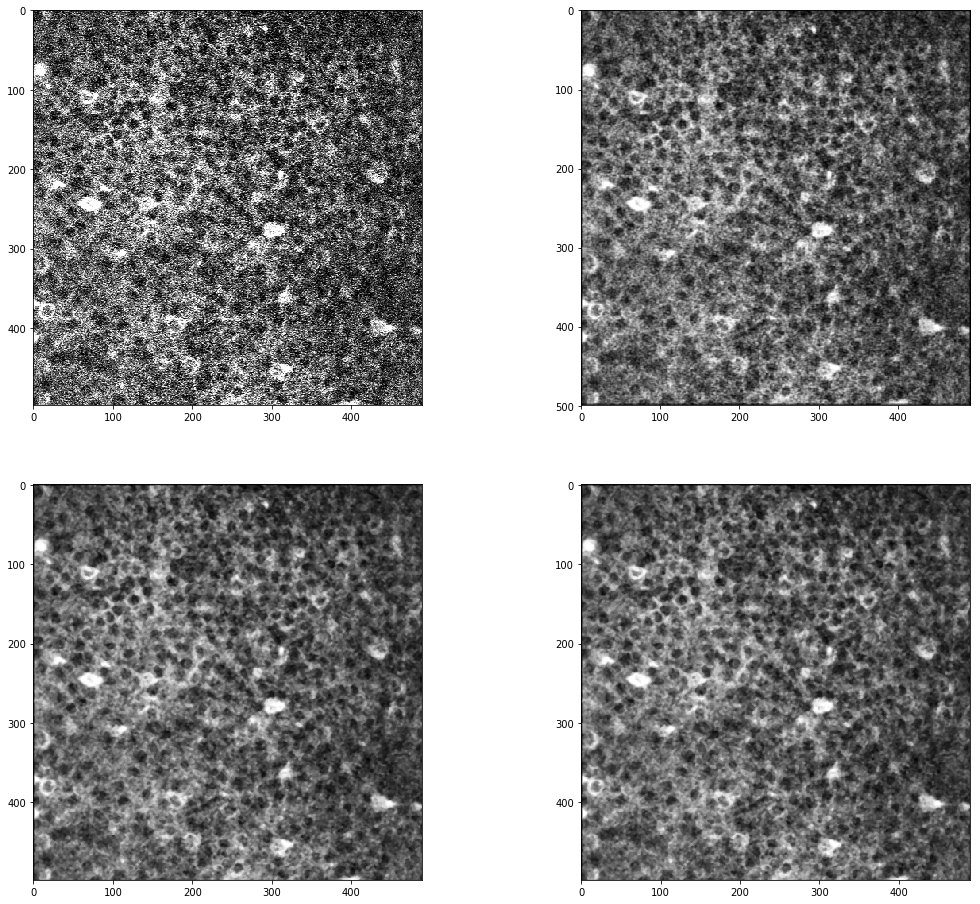

In [16]:
plt.figure(figsize=(18, 16))
plt.subplot(2, 2, 1)
plt.imshow(imgs3[3], cmap='gray')
plt.subplot(2, 2, 2)
plt.imshow(filtered3, cmap='gray')
plt.subplot(2, 2, 3)
plt.imshow(medianConv3[0:498,0:490], cmap='gray')
plt.subplot(2, 2, 4)
plt.imshow(medianConv3Corrected, cmap='gray')
plt.show()

<font size = '+2'>
This is thresholding on a processed image
</font>

In [81]:
thresholded = np.zeros((498,490))
                      
for row in range(0,498):
    for col in range(0,490):
        if medianConv3Corrected[row,col] >= 205:
            thresholded[row, col] = 255


<function matplotlib.pyplot.show(*args, **kw)>

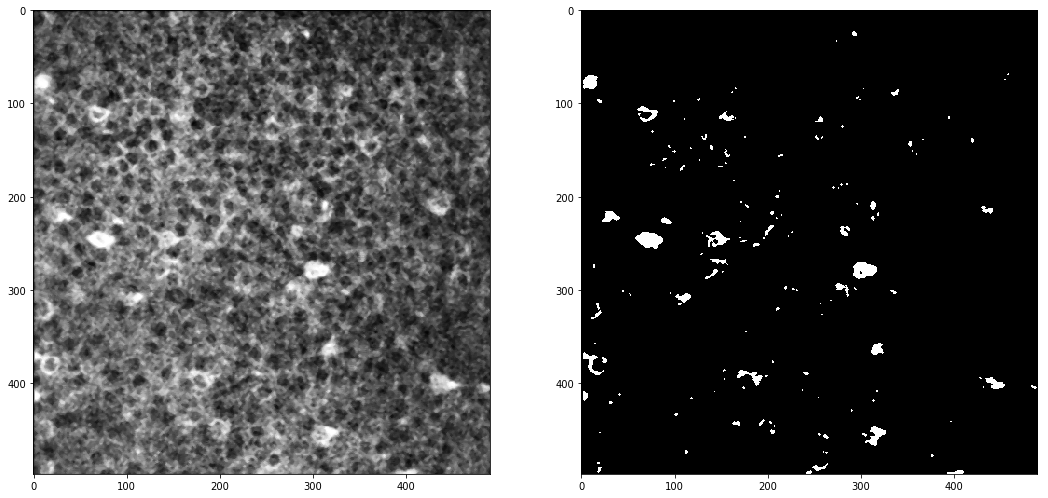

In [82]:
plt.figure(figsize=(18, 16))
plt.subplot(1, 2, 1)
plt.imshow(medianConv3Corrected, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(thresholded, cmap='gray')
plt.show



<function matplotlib.pyplot.show(*args, **kw)>

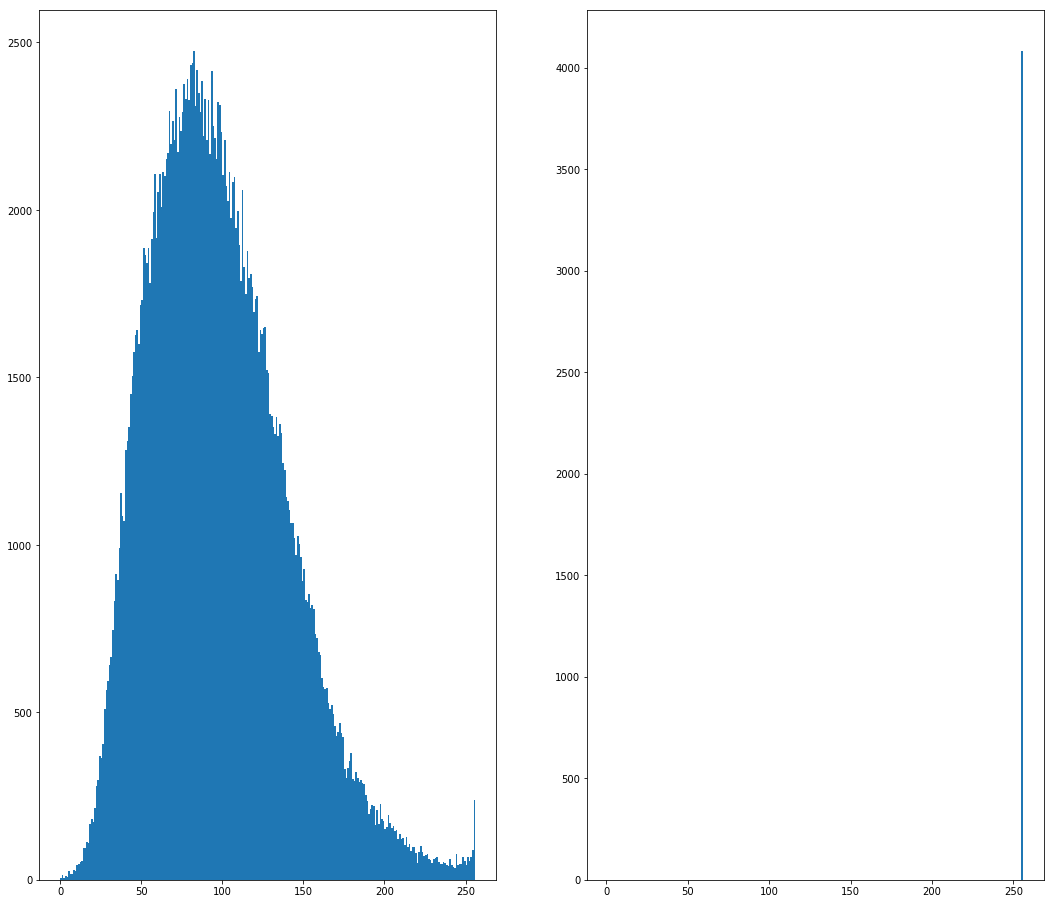

In [83]:
plt.figure(figsize=(18, 16))
plt.subplot(1,2,1)
plt.hist(medianConv3Corrected.ravel(),256,[0,256])
plt.subplot(1,2,2)
# plotting the histogram from 1 since there are soooo many values at 0 that skew the presentation
plt.hist(thresholded.ravel(),255,[1,256])
plt.show

<font size = '+2'>
    Tested thresholding on the non-processed image... It didn't work
</font>

<font size = '+2'>
    Will now compare the mask summation to our generated mask to see if we can create a better generated mask.
</font>

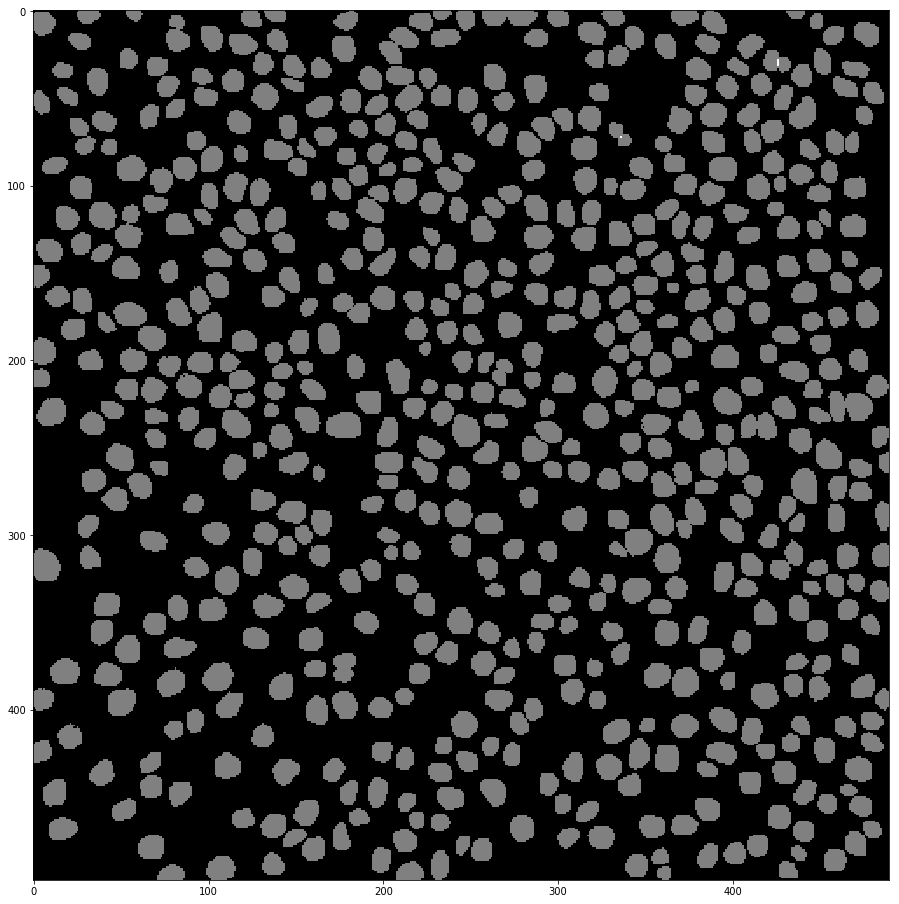

In [84]:
maskSummation = shortMask3.sum(axis = 0)
plt.figure(figsize=(18, 16))
plt.imshow(maskSummation,cmap = 'gray')

In [87]:
test = np.zeros((498,490))
maskIdx = 0
uniqueMaskIdx = []

for mask in shortMask3:
    for row in range(0,498):
        for col in range(0,490):
            if mask[row,col] != 0:
                if thresholded[row,col] != 0:
                    test[row,col] = 255;
                    if maskIdx not in uniqueMaskIdx:
                        uniqueMaskIdx.append(maskIdx)
    maskIdx = maskIdx + 1
    
uniqueMaskIdx = np.asarray(uniqueMaskIdx)

In [88]:
print(uniqueMaskIdx)

[  3  15  32  59  71  89 110 168 175 191 217 222 262 274 297 322 341 360
 394 410 428 442 480 488 498 507 514 515 521 538 555 579 600 604]


In [89]:
relevantSum = np.zeros((498,490))

for val in uniqueMaskIdx:
    relevantSum = relevantSum + shortMask3[val]

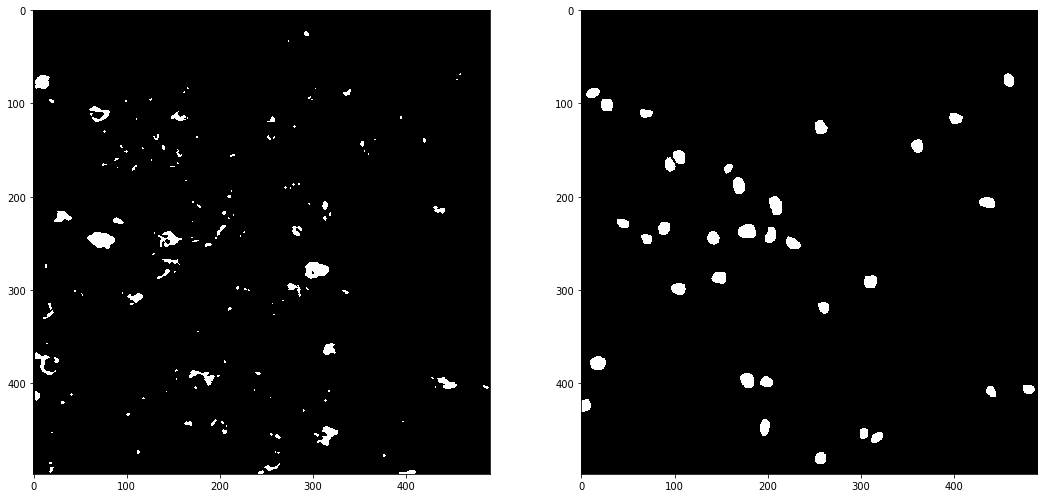

In [90]:
plt.figure(figsize=(18, 16))
plt.subplot(1, 2, 1)
plt.imshow(thresholded, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(relevantSum, cmap='gray')
plt.show()

In [101]:
# from scipy.ndimage import measurements

# lw, num = measurements.label(relevantSum)
# area = measurements.sum(relevantSum, lw, index=range(lw.max() + 1))
# print(area)

# lw1, num1 = measurements.label(thresholded)
# area1 = measurements.sum(thresholded, lw1, index=range(lw1.max() + 1))
# print(area1)


[  0. 124. 117. 146. 114. 125. 167. 149. 159. 140.  82. 197. 212. 162.
 109. 134. 255. 166. 157. 106. 153. 174. 162. 164. 125. 207. 188. 134.
 109.  96. 120. 159.  90. 120. 136.]
[    0.  5100.   765.   765. 49470.   510.   765.   255.  8925.   765.
  1530.  2550.  4590.  1530.  1020. 41565. 22185.  1530.  7140.  1530.
   510.   510.  2040.  1275.  4845.  2805.  1020.  1275.  4080.   510.
  4590.  1530.  4080.   765.  7395.  1530.   510.   510.  3060.  2295.
   765.  1530.  2040.  4335.  2550.   510.   510.  1275.  1020.  1275.
   510.   510.  2550.  1020. 10710.   765.  2295. 15555. 33660.  3315.
  2040.   765.  3060. 15555.   765.   510. 11730. 17085. 54060.   765.
 94605.   510.   510.  1275.  1020.  2550.  6120.  1020. 17595. 85170.
   255.  2040.   255. 13005.   765. 22440.  2295.  1530.  1275.  1785.
  5355.  1020.   765.   255. 25245.   510.   510.  4335.  2295.   255.
  2550.  9945.   510.   510.   510. 31875. 42840.  6885.  1275.  1275.
   765. 45135.  3825.   255.  1275.  102

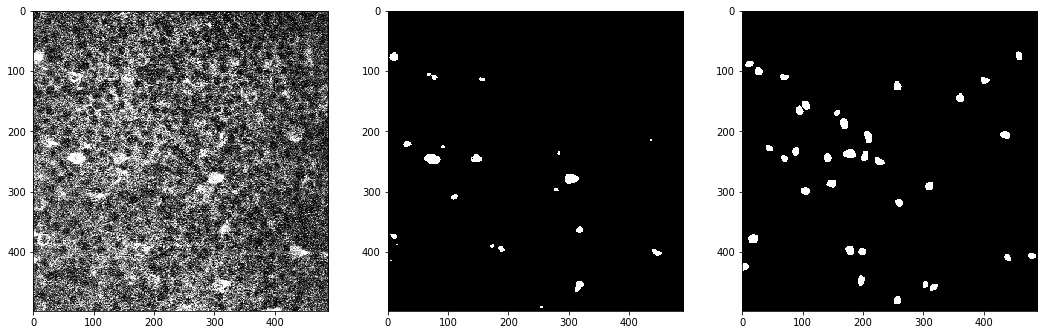

In [128]:
thresholdedMed15 = signal.medfilt(thresholded, 9)
plt.figure(figsize=(18, 16))
plt.subplot(1,3,1)
plt.imshow(imgs3[3], cmap = 'gray')
plt.subplot(1,3,2)
plt.imshow(thresholdedMed15, cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(relevantSum, cmap = 'gray')
plt.show()

In [129]:
finalMaskIdx = []
maskIdx = 0

for mask in shortMask3:
    for row in range(0,498):
        for col in range(0,490):
            if mask[row,col] != 0:
                if thresholdedMed15[row,col] != 0:
                    if maskIdx not in finalMaskIdx:
                        finalMaskIdx.append(maskIdx)
    maskIdx = maskIdx + 1
    
finalMaskIdx = np.asarray(finalMaskIdx)
print(finalMaskIdx)

finalMask = np.zeros((498,490))
for val in finalMaskIdx:
    finalMask = finalMask + shortMask3[val]

[ 32 110 274 394 410 514 579 604]


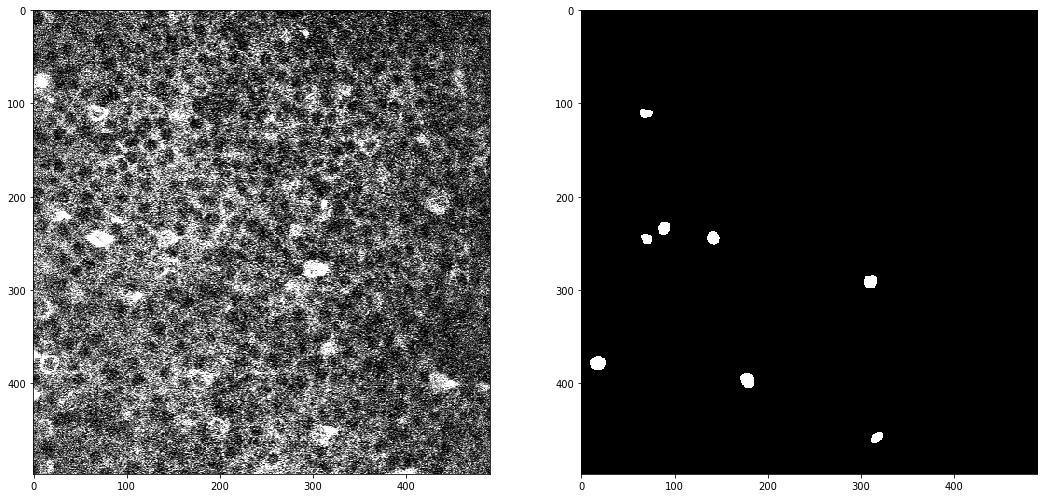

In [130]:
plt.figure(figsize=(18, 16))
plt.subplot(1,2,1)
plt.imshow(imgs3[3], cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(finalMask, cmap = 'gray')
plt.show()

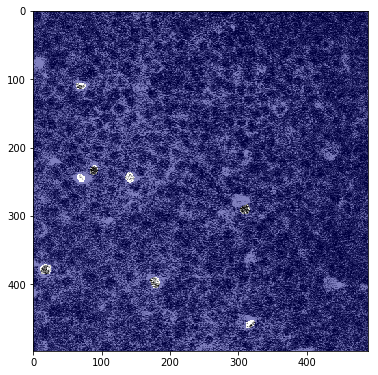

In [140]:
plt.figure(figsize=(6, 16))
plt.imshow(imgs3[3], cmap = 'gray')
Img2 = np.ma.masked_array(finalMask == 0, finalMask)
plt.imshow(Img2, cmap = 'jet', alpha = .5)
plt.show()

In [ ]:
-change median filter to be the size of the smallest neuron
-label all of the neuron patches so each patch will have a different number and multiply with the half masks to generate
-sliding window to generate the middle mask